We give here an example of application of `digdem` with input files and parameters provided by external files. We use Mount Rainier as a case study, and construct an hypothetic collapse near the summit crater. **This collapse scar does not correspond to any possible collapse investigated by the USGS, academics or any organization. It does not rely on any geotechnical/geological/geophysical data. Its sole purpose is to illustrate how `digdem` can be used with rasters**. 

The topography of Mount Rainier was downloadas from OpenTopography: 

- National Park Service. (2023). Survey of Mount Rainier, WA, 2021. Distributed by OpenTopography.
https://urldefense.com/v3/__https://doi.org/10.5069/G92Z13Q7__;!!KbSiYrE!lMSHzlnutSQLEnXnDm3RRwj2Ck7TAovAgCd_5o-dir_CIRxv-HSMu_jNJxA2vBKiutCIMInfVM6NyL3IIz3r2g$ . Accessed: 2024-01-08
- License: CC BY 4.0

Start by importing necessary packages and modules

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

import digdem.surfmod
import digdem.section
import digdem.download_data
import digdem.gis
import digdem.plot

Download the necessary data to run the example. The following function downloads:
- `raster_rainier.tif` : the initial topography in .tif format
- `scar.shp` and associated .dbf, .shx and .prj files : polygon shapefile delimiting the area where the topography will be modified
- `sections.shp` and associated .dbf, .shx and .prj files : lines shapefile with one feature per control section. One of the field is `name` and contains the name of the sections (e.g. "A-A'", to "D-D'"). An optional field is `ori` (with value either "S-N", "N-S", "E-W" or "W-E") that is used to orient the section. E.g. if section has name "A-A'" and orientation "E-W", the extremity point A will be the western most line extremity.
- `sections_control_points.txt`: Text file containing the control points for all sections, identified by their name preceded by `#`. For each section, the first column is the x-coordinate of the given control point along the section, or the name of the other section it intersects. The second column is the altitude. All section do not need to be listed, if no control point is specified. E.g. for three sections "A-B", "C-D", "E-F", with "A-B" intersecting "C-D" and "E-F" a valid format is:
  > #A-B  
  C-D 10.1  
  E-F 40.6  
  50.4 60  
  #E-F  
  10 30.4
- `sup_interp_points.txt`: text file with the coordinates and altitudes of supplementary interpolation points. First column is the X coordinate, second column is the Y coordinate, and thrid column is the altitude. E.g. a valid format is:
  >20 40.1 30  
  >30.9 35 20.3

In [2]:
digdem.download_data.import_rainier_data()

Read the initial topography and plot it, along with sections and scar mask

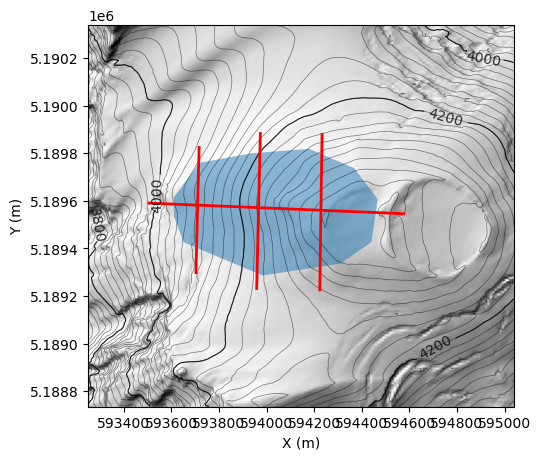

In [3]:
x, y, z = digdem.gis.read_raster("./raster_rainier.tif")
scar = gpd.read_file("./scar.shp")
sections = gpd.read_file("./sections.shp")

fig, axe = plt.subplots(1, 1, figsize=(14 / 2.54, 14 / 2.54))
digdem.plot.plot_topo(z, x, y, indexing="raster", axe=axe)
scar.plot(ax=axe, alpha=0.5)
sections.plot(ax=axe, lw=2, color="red")
fig.tight_layout()

`digdem` must be provided with an array or a raster to identify where the surface must be modified. `digdem` comes with a tool to convert a polygon shapefile to the corresponding mask as a raster. 

In [4]:
digdem.gis.rasterize_shapefile(
    "./scar.shp", "./scar.tif", raster_ref="./raster_rainier.tif")
_, _, mask = digdem.gis.read_raster("./scar.tif")

You can work directly with a mask raster that you construct with a third party. However shapefiles are more easily modified manually (e.g. in QGIS) than rasters, and it is most likely that you will need to change the mask extent by trial and error. Thus, creating the mask raster directly from the shapefile, within your python script, will make modifications easier.

You can nowinitiatie the SurfMod instance. The parameters include: 
- `indexing` (default `"ij"`): Specify how the mask and initial topography arrays are indexed. `"ij"` implies that `array[0, 0]` has coordinates `x[0]` and `y[0]`, `array.shape[0] == len(x)` and `array.shape[1] == len(y)`. "raster" means that `array[0, 0]` has coordinates `x[0]` and `y[-1]`, `array.shape[0] == len(Y)` and `array.shape[1] == len(x)`.
- `dinterp` (default 10): Distance in meters between interpolation points computed along sections and along the contour of the area to be modified.
- `sparse_interp` (default 1): Step between indexes to generate the regular grid from `surf_old` that will be used to compute the RectBivariateSpline interpolating function for the old surface. E.g. if `sparse_interp` is 3, one point out of the 3 in the x and y directions will be used.
- `smooth`(default 0.5): Smoothing factor used in `scipy.interpolate.Rbf` to interpolate the new surface from the interpolation points.

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='X (m)', ylabel='Y (m)'>)

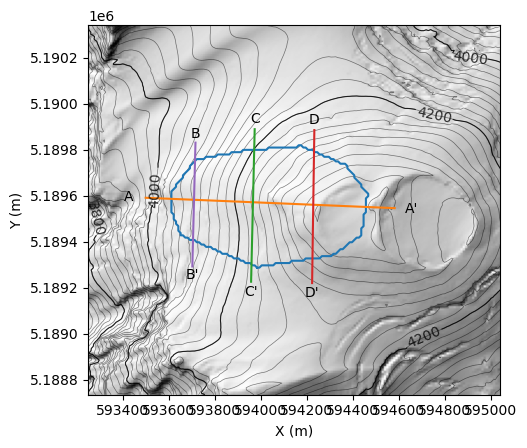

In [5]:
new_dem = digdem.surfmod.SurfMod(
    z,
    mask=mask,
    xaxis=x,
    yaxis=y,
    indexing="raster",
    dinterp=40,
    smooth=0.1,
    sparse_interp=1,
    sections="./sections.shp",
)
new_dem.plot()

You can now add the control points on the section, as well as supplementary interpolation points, and update the surface interpolation.

In [6]:
new_dem.set_control_points("sections_control_points.txt")
new_dem.set_sup_interp_points("sup_interp_points.txt")
new_dem.update_interpolation()

Plot now results. You can provide some properties for plotting sections, letters for profiles extremities. Here we also specify `plot_inter_points=True` to display interpolation points.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': "D-D'"}, xlabel='Distance (m)', ylabel='Altitude (m)'>)

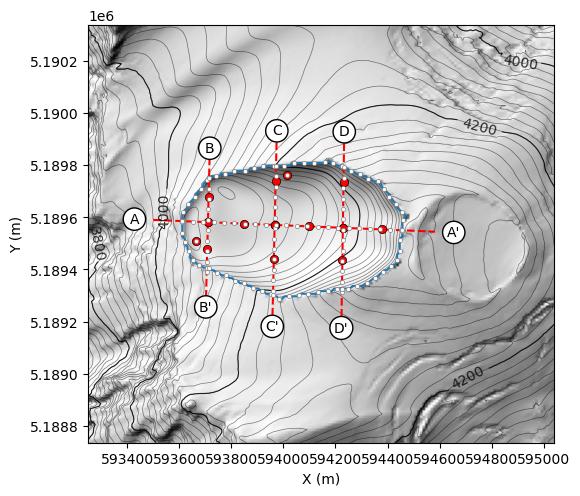

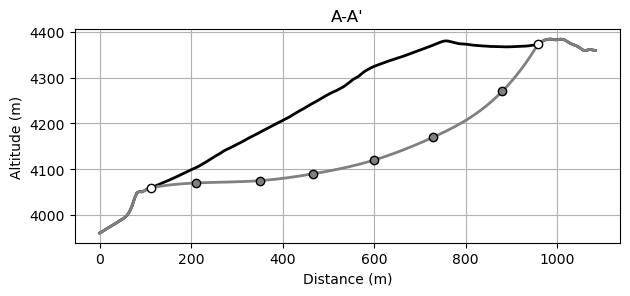

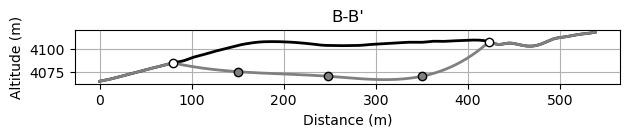

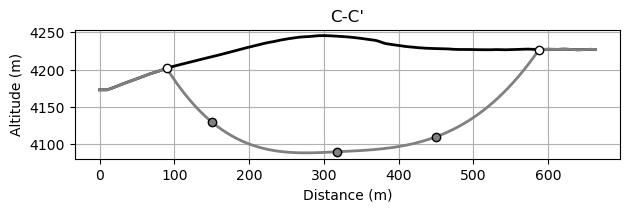

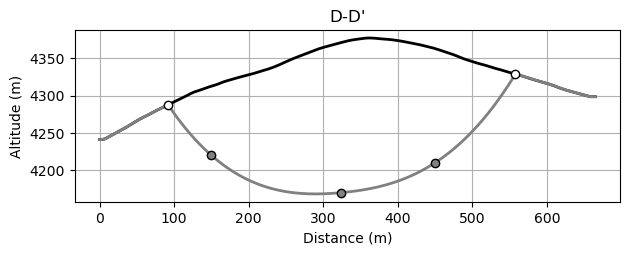

In [10]:
# Properties for plotting sections
section_kwargs = {"linestyle": "--", "linewidth": 1.5, "color": "r"}
# Properties for text display (names of section extremities)
text_kwargs = {
    "size": 10,
    "color": "k",
    "bbox": dict(boxstyle="circle", fc="w", ec="k", pad=0.3),
}
# Propoerties for control points
control_points_kwargs = {
    "marker": "o",
    "ms": 6,
    "mec": "k",
    "mew": 0.5,
    "mfc": "r",
}
interp_points_kwargs = {
    "linestyle": "None",
    "marker": "o",
    "ms": 3,
    "mfc": "w",
    "mec": [0.5, 0.5, 0.5],
    "mew":0.5
}
fig, axe = new_dem.plot(
    figsize=(15 / 2.54, 14 / 2.54),
    section_properties=section_kwargs,
    text_properties=text_kwargs,
    control_points_properties=control_points_kwargs,
    interp_points_properties=interp_points_kwargs,
    plot_interp_points=True,
)
fig.tight_layout()
fig.savefig('./new_dem.png')
new_dem["A-A'"].plot()
new_dem["B-B'"].plot()
new_dem["C-C'"].plot()
new_dem["D-D'"].plot()

To post-process the new topography in a GIS software, you can export the new surface to a raster: 

In [9]:
new_dem.save_to_raster("./new_dem.tif", raster_ref="./raster_rainier.tif")

`new_dem.save_to_raster("./new_dem.tif")` will also work but the projection properties of `raster_rainier.tif` will not be set. You can specify them manually by giving the EPSG code (in this case "EPSG:26910") with `new_dem.save_to_raster("./new_dem.tif", crs='EPSG:26910')`.